# MMA 867 - Predictive Modelling
# Team Project - Team Beijing
### August 24, 2024


##### Packages and Modules

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import os
from os.path import curdir
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, PolynomialFeatures, scale, StandardScaler, RobustScaler, PowerTransformer
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
#from sklearn import preprocessing 
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, classification_report, mean_squared_error, r2_score
#from sklearn import metrics
from scipy.stats import boxcox, yeojohnson
from sklearn.feature_selection import RFE

#### Notebook Setup
Load in and examine the car price dataset that we are going to use to predict car prices

In [46]:
# Load data from a CSV file
car_data = pd.read_csv("CarPrice_Assignment.csv")
car_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

In [47]:
#Interpret summary statistics for all the variables
car_data.describe()

,car_ID,symboling,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,103.000000,0.834146,98.756585,174.049268,65.907805,53.724878,2555.565854,126.907317,3.329756,3.255415,10.142537,104.117073,5125.121951,25.219512,30.751220,13276.710571
std,59.322565,1.245307,6.021776,12.337289,2.145204,2.443522,520.680204,41.642693,0.270844,0.313597,3.972040,39.544167,476.985643,6.542142,6.886443,7988.852332
min,1.000000,-2.000000,86.600000,141.100000,60.300000,47.800000,1488.000000,61.000000,2.540000,2.070000,7.000000,48.000000,4150.000000,13.000000,16.000000,5118.000000
25%,52.000000,0.000000,94.500000,166.300000,64.100000,52.000000,2145.000000,97.000000,3.150000,3.110000,8.600000,70.000000,4800.000000,19.000000,25.000000,7788.000000
50%,103.000000,1.000000,97.000000,173.200000,65.500000,54.100000,2414.000000,120.000000,3.310000,3.290000,9.000000,95.000000,5200.000000,24.000000,30.000000,10295.000000
75%,154.000000,2.000000,102.400000,183.100000,66.900000,55.500000,2935.000000,141.000000,3.580000,3.410000,9.400000,116.000000,5500.000000,30.000000,34.000000,16503.000000
max,205.000000,3.000000,120.900000,208.100000,72.300000,59.800000,4066.000000,326.000000,3.940000,4.170000,23.000000,288.000000,6600.000000,49.000000,54.000000,45400.000000


#### Data Clean Up
Use the Car_Name column to create a Car_Make column so the model can use car brands as a factor to predict car price. Also drop the car_ID field which is redundant for our model.

In [48]:
# Drop the car_ID column
car_data = car_data.drop('car_ID', axis=1)

# Change Car_Name from model to brand
car_data['CarMake'] = car_data['CarName'].str.split(" ", expand=True)[0]
car_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   symboling         205 non-null    int64  
 1   CarName           205 non-null    object 
 2   fueltype          205 non-null    object 
 3   aspiration        205 non-null    object 
 4   doornumber        205 non-null    object 
 5   carbody           205 non-null    object 
 6   drivewheel        205 non-null    object 
 7   enginelocation    205 non-null    object 
 8   wheelbase         205 non-null    float64
 9   carlength         205 non-null    float64
 10  carwidth          205 non-null    float64
 11  carheight         205 non-null    float64
 12  curbweight        205 non-null    int64  
 13  enginetype        205 non-null    object 
 14  cylindernumber    205 non-null    object 
 15  enginesize        205 non-null    int64  
 16  fuelsystem        205 non-null    object 
 1

#### Clean Up Typos in the Data
Some of the car brand names are types out wrong. To fix this we need to first find out all the possible values for the CarMake column and then individually correct them.

In [49]:
#Find mistyped 
car_data['CarMake'].unique()

array(['alfa-romero', 'audi', 'bmw', 'chevrolet', 'dodge', 'honda',
       'isuzu', 'jaguar', 'maxda', 'mazda', 'buick', 'mercury',
       'mitsubishi', 'Nissan', 'nissan', 'peugeot', 'plymouth', 'porsche',
       'porcshce', 'renault', 'saab', 'subaru', 'toyota', 'toyouta',
       'vokswagen', 'volkswagen', 'vw', 'volvo'], dtype=object)

In [50]:
car_data.loc[car_data['CarMake'] == 'toyouta', 'CarMake'] = 'toyota'
car_data.loc[car_data['CarMake'] == 'vw', 'CarMake'] = 'volkswagen'
car_data.loc[car_data['CarMake'] == 'vokswagen', 'CarMake'] = 'volkswagen'
car_data.loc[car_data['CarMake'] == 'porcshce', 'CarMake'] = 'porsche'
car_data.loc[car_data['CarMake'] == 'Nissan', 'CarMake'] = 'nissan'
car_data.loc[car_data['CarMake'] == 'maxda', 'CarMake'] = 'mazda'

car_data.head()

,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,...,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price,CarMake
0,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,168.8,...,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0,alfa-romero
1,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,168.8,...,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0,alfa-romero
2,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,171.2,...,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0,alfa-romero
3,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,176.6,...,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0,audi
4,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,176.6,...,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0,audi


#### Feature Engineering
Brand Reputation - Using information collected from research, we'll assign a brand repudation score to the different Car Makes and assign that score to a column in our dataset. This is because not all car brands are of equal value and this helps account for that.

In [51]:
# Define the brand reputation scores
brand_reputation = {
    'alfa-romero': 4,
    'audi': 4,
    'bmw': 5,
    'chevrolet': 2,
    'dodge': 2,
    'honda': 3,
    'isuzu': 1,
    'jaguar': 4,
    'mazda': 3,
    'buick': 3,
    'mercury': 2,
    'mitsubishi': 3,
    'nissan': 3,
    'peugeot': 1,
    'plymouth': 2,
    'porsche': 5,
    'renault': 1,
    'saab': 3,
    'subaru': 3,
    'toyota': 3,
    'volkswagen': 3,
    'volvo': 4
}

# Apply the brand reputation to the dataset
car_data['Brand Reputation'] = car_data['CarMake'].map(brand_reputation)

car_data = car_data.drop(columns='CarName')


Adjusting Skewness - We'll use boxplots to visualize the distribution and variance among our independent and dependent variables to identify skewness and apply transformations to reduce skewness for stronger predicting power in our final model.

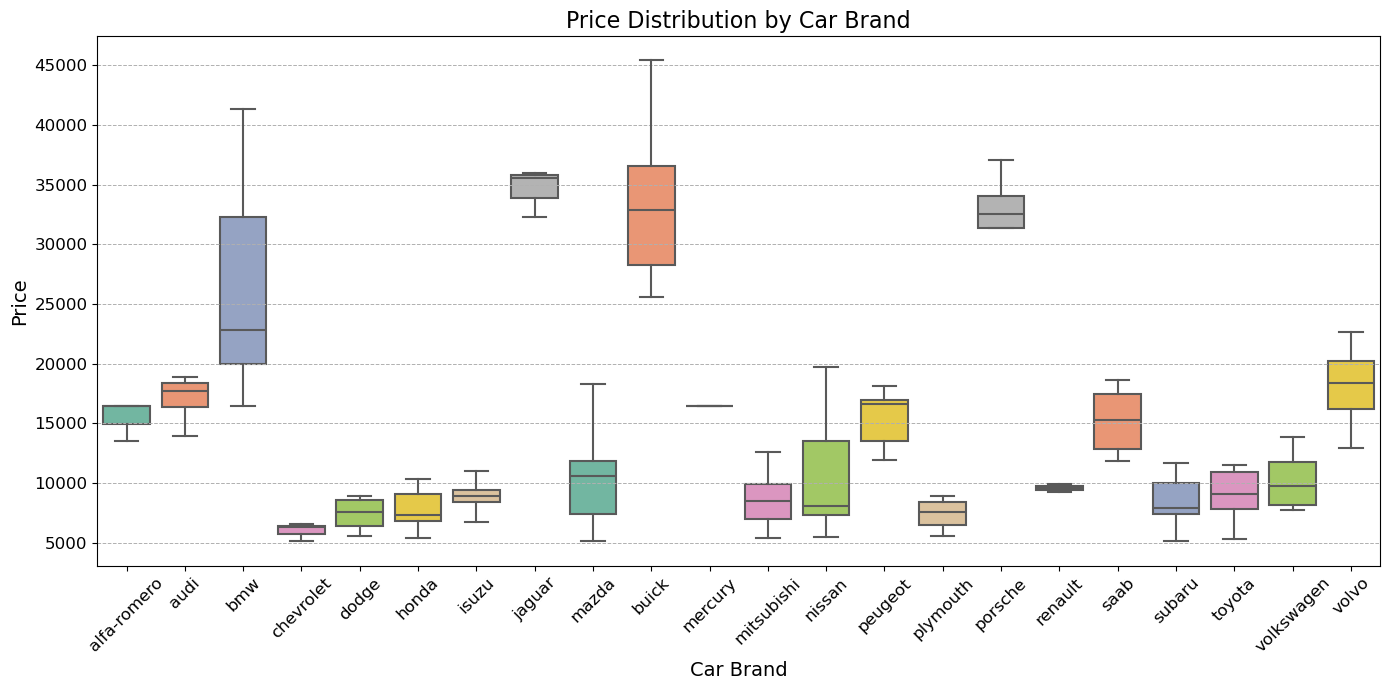

In [52]:
# Enhanced Box plot to visualize price distribution across different car brands
plt.figure(figsize=(14, 7))

# Use a custom color palette for better aesthetics
sns.boxplot(x='CarMake', y='price', data=car_data, palette="Set2", showfliers=False)

# Add labels and title with larger font sizes for readability
plt.xlabel('Car Brand', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.title('Price Distribution by Car Brand', fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.7)
plt.tight_layout()

# Show the plot
plt.show()

C:\Users\ronka\AppData\Local\Temp\ipykernel_10288\3101559662.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(car_data['price'], color='g', bins=100, hist_kws={'alpha': 0.4});
c:\Users\ronka\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Car Sale Price Skewness:  1.7776781560914454


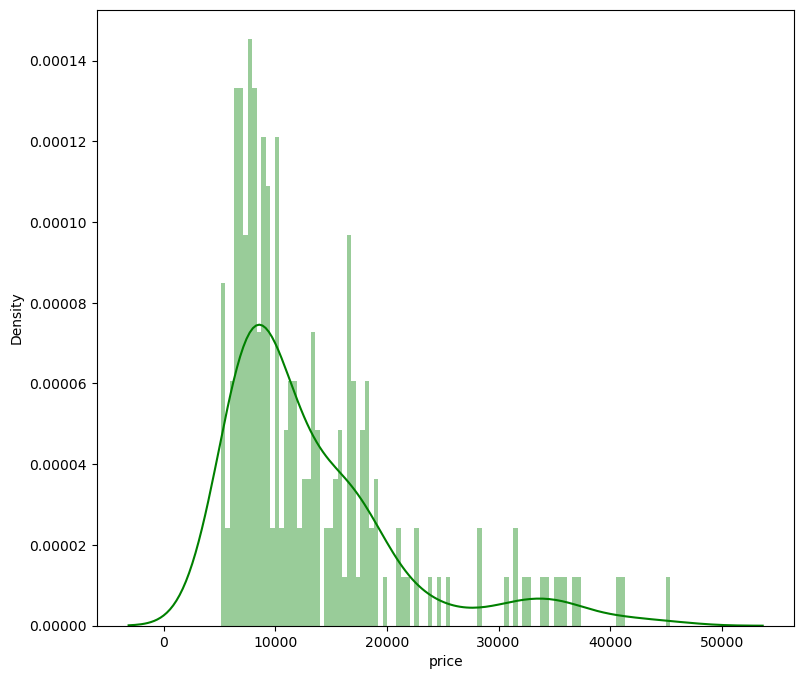

In [53]:
plt.figure(figsize=(9, 8))
sns.distplot(car_data['price'], color='g', bins=100, hist_kws={'alpha': 0.4});
print("Car Sale Price Skewness: ", car_data['price'].skew())

In [54]:
#Apply a logarithm to our dependent variable to make it more normal.
car_data['price'] = np.log1p(car_data['price'])

C:\Users\ronka\AppData\Local\Temp\ipykernel_10288\3101559662.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(car_data['price'], color='g', bins=100, hist_kws={'alpha': 0.4});
c:\Users\ronka\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Car Sale Price Skewness:  0.6729635607485753


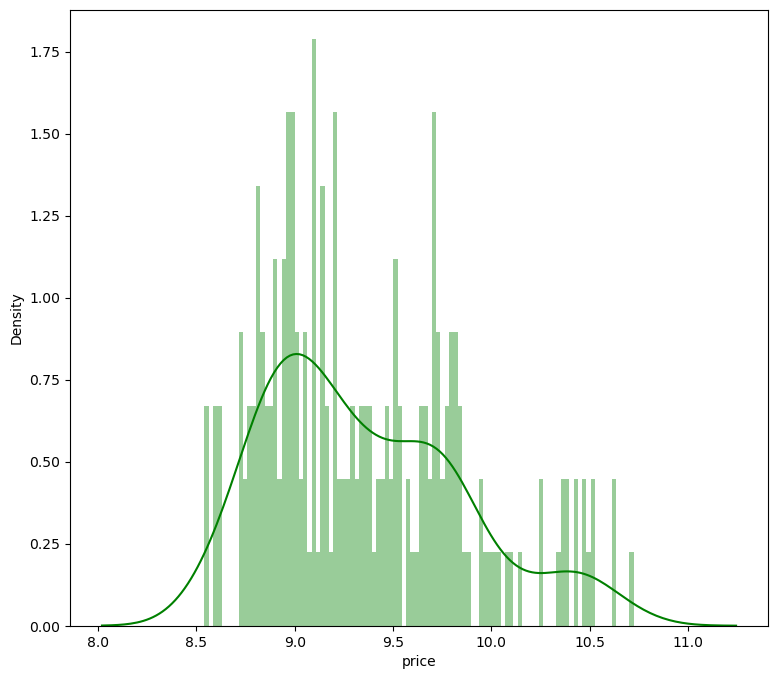

In [55]:
plt.figure(figsize=(9, 8))
sns.distplot(car_data['price'], color='g', bins=100, hist_kws={'alpha': 0.4});
print("Car Sale Price Skewness: ", car_data['price'].skew())

#### Split the Data 
Now we splt the data into an X dataset with the predictors and Y dataset with the target values. During this process we will also do any feature encoding for our categorical variables before splitting our data into training and test datasets.

In [56]:
# Prepare the features (X) and target (Y)
X = car_data.drop(columns=['price'])  
Y = car_data['price']  

categorical_columns = X.select_dtypes(include=['object'])

# Encode categorical variables (if any) using pd.get_dummies
X_encoded = pd.get_dummies(categorical_columns, drop_first=True).astype('int64')

X2 = X.drop(categorical_columns.columns, axis=1)
X2 = pd.concat([X2, X_encoded], axis=1)
X2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 65 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   symboling              205 non-null    int64  
 1   wheelbase              205 non-null    float64
 2   carlength              205 non-null    float64
 3   carwidth               205 non-null    float64
 4   carheight              205 non-null    float64
 5   curbweight             205 non-null    int64  
 6   enginesize             205 non-null    int64  
 7   boreratio              205 non-null    float64
 8   stroke                 205 non-null    float64
 9   compressionratio       205 non-null    float64
 10  horsepower             205 non-null    int64  
 11  peakrpm                205 non-null    int64  
 12  citympg                205 non-null    int64  
 13  highwaympg             205 non-null    int64  
 14  Brand Reputation       205 non-null    int64  
 15  fuelty

In [57]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X2, Y, test_size=0.2, random_state=42)

#### Transformations
Standardize the predictors so that they all have a mean of 0.

In [58]:
# Standardize the features (Lasso requires features to be on the same scale)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


#### Fitting the Model
We now fit a lasso regression model. To ensure the most optimal model we use 5-fold cross validation to find the best possible alpha for our model.

In [59]:
# Define a range of alpha values to search over
params = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

# Initialize GridSearchCV with Lasso
lasso_cv = GridSearchCV(Lasso(), param_grid=params, cv=5)
lasso_cv.fit(X_train_scaled, y_train)

# Best alpha found
print("Best alpha:", lasso_cv.best_params_)

Best alpha: {'alpha': 0.01}


Finds the best alpha for Lasso by testing multiple values and selecting the one that gives the best model performance through cross-validation. It helps balance between overfitting and underfitting.

In [60]:
# Train the Lasso regression model
lasso = Lasso(alpha=0.01)  
lasso.fit(X_train_scaled, y_train)

# Make predictions
y_train_pred = lasso.predict(X_train_scaled)
y_test_pred = lasso.predict(X_test_scaled)

y_train = np.exp(y_train)
y_test = np.exp(y_test)

y_train_pred = np.exp(y_train_pred)
y_test_pred = np.exp(y_test_pred)



#### Evaluate the Model

In [61]:
# Evaluate the model
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f'Training RMSE: {train_rmse}')
print(f'Testing RMSE: {test_rmse}')
print(f'Training R^2: {train_r2}')
print(f'Testing R^2: {test_r2}')

Training RMSE: 1578.2082658240831
Testing RMSE: 2278.3420845026685
Training R^2: 0.9582355524699167
Testing R^2: 0.9342465382916221


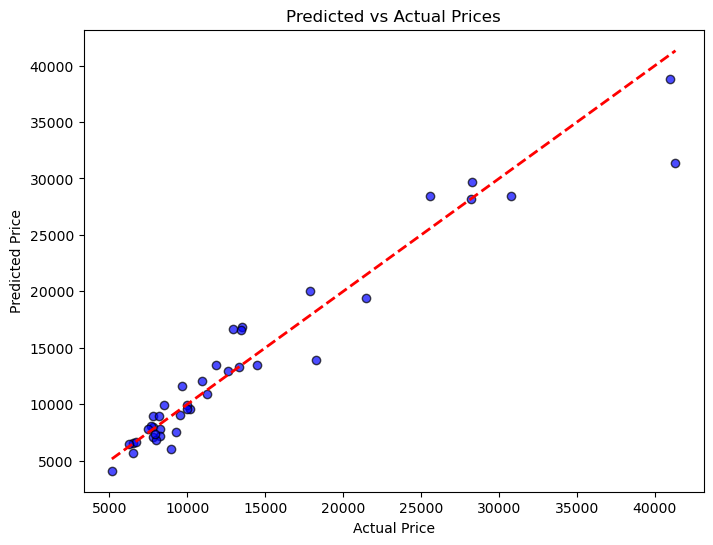

In [62]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, color='blue', edgecolors='k', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Predicted vs Actual Prices')
plt.show()

In [63]:
# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
print(f"MAPE: {mape:.2f}%")

MAPE: 10.76%


A MAPE of 10.76% means that, on average, the model's predicted car prices deviate from the actual prices by about 10.76%.

In [64]:
# DataFrame with actual and predicted values
comparison_df = pd.DataFrame({
    'Actual Price': y_test,
    'Predicted Price': y_test_pred
})

# Calculate the percentage change between actual and predicted prices
comparison_df['Percentage Change'] = ((comparison_df['Predicted Price'] - comparison_df['Actual Price']) / comparison_df['Actual Price']) * 100

# Display the first 10 rows of the DataFrame
print(comparison_df.head(10))

     Actual Price  Predicted Price  Percentage Change
15      30761.000     28475.637950          -7.429414
9       17860.167     20029.624073          12.146903
100      9550.000      9033.573694          -5.407605
132     11851.000     13508.133482          13.983069
68      28249.000     29641.902896           4.930804
95       7800.000      7051.439496          -9.596930
159      7789.000      7956.397886           2.149158
162      9259.000      7497.845826         -19.020998
147     10199.000      9553.635198          -6.327726
182      7776.000      8955.850395          15.172973


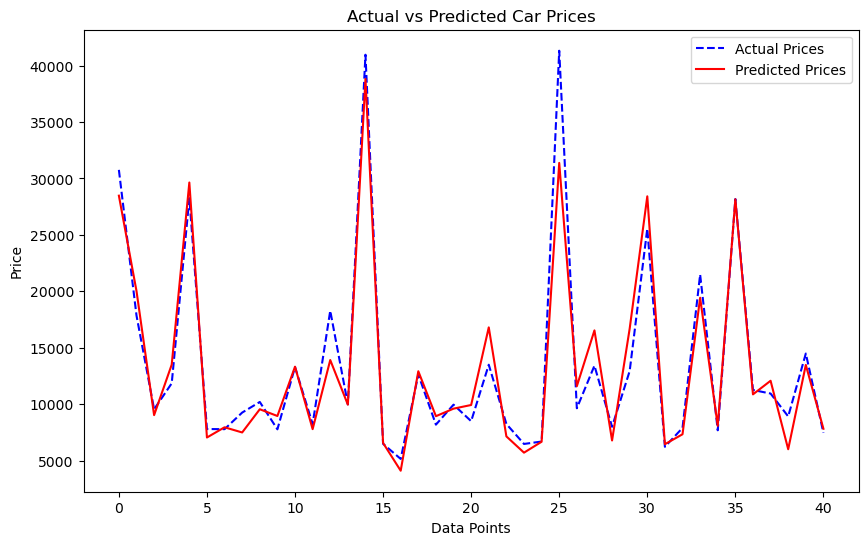

In [65]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Prices', color='b', linestyle='--')
plt.plot(y_test_pred, label='Predicted Prices', color='r')
plt.xlabel('Data Points')
plt.ylabel('Price')
plt.title('Actual vs Predicted Car Prices')
plt.legend()
plt.show()

In [66]:
# Sort the feature importance by magnitude
feature_importance = pd.Series(lasso.coef_, index=X_train.columns)
feature_importance = feature_importance.sort_values(key=abs, ascending=False)

print("Top features influencing car sales (Lasso):")
print(feature_importance.head())  

Top features influencing car sales (Lasso):
curbweight             0.232784
Brand Reputation       0.070409
enginelocation_rear    0.066716
carwidth               0.060622
horsepower             0.045789
dtype: float64


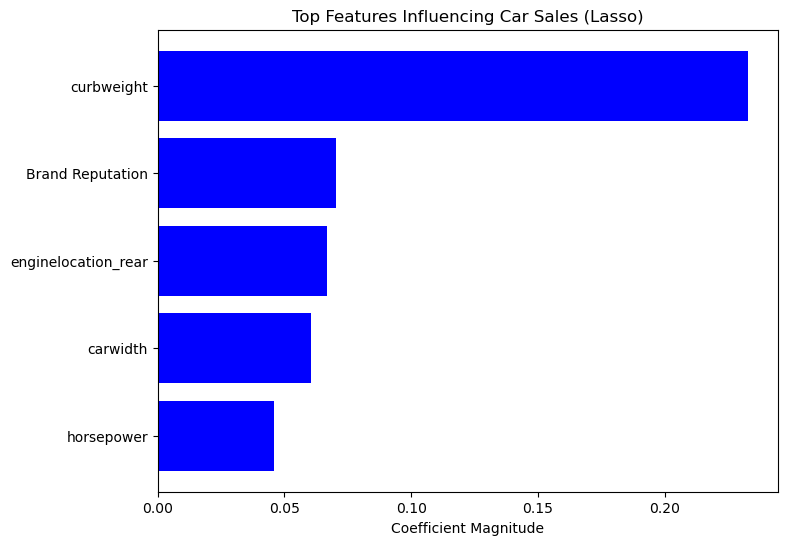

In [67]:
# Data for the top features influencing car sales
features = ['curbweight', 'Brand Reputation', 'enginelocation_rear', 'carwidth', 'horsepower']
importance = [0.232784, 0.070409, 0.066716, 0.060622, 0.045789]

# Create a DataFrame
car_data = pd.DataFrame({'Feature': features, 'Importance': importance})

# Plotting
plt.figure(figsize=(8, 6))
plt.barh(car_data['Feature'], car_data['Importance'], color='blue')
plt.xlabel('Coefficient Magnitude')
plt.title('Top Features Influencing Car Sales (Lasso)')
plt.gca().invert_yaxis()  
plt.show()

In [68]:
subset = feature_importance.iloc[0:28]  
print(subset)

curbweight             0.232784
Brand Reputation       0.070409
enginelocation_rear    0.066716
carwidth               0.060622
horsepower             0.045789
citympg               -0.042603
CarMake_bmw            0.036854
CarMake_buick          0.030347
drivewheel_rwd         0.024627
CarMake_toyota        -0.024404
fuelsystem_2bbl       -0.023509
carbody_wagon         -0.020801
fuelsystem_mpfi        0.019528
CarMake_mitsubishi    -0.018866
CarMake_subaru        -0.015292
fueltype_gas          -0.012081
carbody_hatchback     -0.010886
CarMake_saab           0.010876
CarMake_audi           0.010766
CarMake_porsche        0.010111
CarMake_isuzu          0.007838
enginetype_rotor       0.007617
aspiration_turbo       0.004914
CarMake_nissan        -0.004354
fuelsystem_idi         0.003847
cylindernumber_two     0.002035
fuelsystem_spfi       -0.000000
CarMake_chevrolet      0.000000
dtype: float64


In [69]:
# Sort feature importance by magnitude
feature_importance = pd.Series(lasso.coef_, index=X_train.columns)

# Get magnitudes of the coefficients (absolute values)
feature_magnitudes = feature_importance.abs().sort_values(ascending=False)

# Print all feature magnitudes
print("All feature importance magnitudes (sorted):")
print(feature_magnitudes)

All feature importance magnitudes (sorted):
curbweight              0.232784
Brand Reputation        0.070409
enginelocation_rear     0.066716
carwidth                0.060622
horsepower              0.045789
                          ...   
cylindernumber_five     0.000000
wheelbase               0.000000
cylindernumber_six      0.000000
cylindernumber_three    0.000000
CarMake_volvo           0.000000
Length: 65, dtype: float64
